# Module 3 Project

#### 1. Adapt the code from class that reads GHCN Daily Data from Amazon Web Services and write a function that will download the station you want (called with a GHCN station ID), and calculate the all time record high and low and the normal (mean) high and low temperature for the 1991-2020 period for the desired station and returns a pandas data frame with the columns ['record_min_temp', average_min_temp', 'average_max_temp', record_max_temp']. Write a code that can call this function and successfully demonstrate that it works.

In [34]:
# import libraries
import pandas as pd
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [67]:
def get_temp_extrema(ghcn_id='USW00023188', start_yr=1991, end_yr=2020):
    '''
    Calculates the record and mean temperature extrema for any GHCN weather 
    station for the desired range of years
    '''

    # import daily station data 
    df = pd.read_parquet(
        "s3://noaa-ghcn-pds/parquet/by_station/STATION=" + ghcn_id + "/",
        storage_options={"anon": True})  # passed to `s3fs.S3FileSystem`
    # create date index 
    df['DATE'] = pd.to_datetime(df['DATE'].apply(
        lambda x: datetime.strptime(x, '%Y%m%d')))
    df = df.set_index('DATE').sort_index()

    # subset desired time range and station min & max temps into two dfs
    df = df[(df.index.year >= start_yr) & (df.index.year <= end_yr)]
    min_temps = df[df['ELEMENT'].isin(['TMIN'])]
    max_temps = df[df['ELEMENT'].isin(['TMAX'])]
    
    final_temps = pd.DataFrame({
        'record_min_tempC': [min_temps['DATA_VALUE'].min() / 10],
        'average_min_tempC': [min_temps['DATA_VALUE'].mean() / 10],
        'record_max_tempC': [max_temps['DATA_VALUE'].max() / 10],
        'average_max_tempC': [max_temps['DATA_VALUE'].mean() / 10]
        })
    return final_temps

get_temp_extrema()

,record_min_tempC,average_min_tempC,record_max_tempC,average_max_tempC
0,1.7,14.573554,38.3,21.360622


#### 2. Develop a plot (using matplotlib) that displays for the city of choice a plot showing the record, average, and actual high and low temperatures for that year and city (San Diego, 2020).

In [176]:
def get_annual_temp_stats(ghcn_id='USW00023188', yr=2020, 
        start_yr=1991, end_yr=2020):
    '''
    Calculates daily temperature extrema for a desired year of any GHCN
    weather station and daily record and mean temperature extrema over a
    desired range of N years
    '''

    # import daily station data 
    df = pd.read_parquet(
        "s3://noaa-ghcn-pds/parquet/by_station/STATION=" + ghcn_id + "/",
        storage_options={"anon": True})  # passed to `s3fs.S3FileSystem`
    # create date index and MMDD (month-day) column
    df['DATE'] = pd.to_datetime(df['DATE'].apply(
        lambda x: datetime.strptime(x, '%Y%m%d')))
    df = df.set_index('DATE').sort_index()
    # remove leap year days (Feb 29s)
    df = df[~((df.index.month == 2) & (df.index.day == 29))]
    # create Day and Month columns for grouping
    df['Day'] = df.index.day
    df['Month'] = df.index.month
    # apply unit correction of DATA_VALUE column for temps
    df['DATA_VALUE'] = df['DATA_VALUE'] / 10
    # subset desired year range 
    df = df[(df.index.year >= start_yr) & (df.index.year <= end_yr)]

    # create two dataframes for station min & max temps 
    min_temps = df[df['ELEMENT'].isin(['TMIN'])]
    max_temps = df[df['ELEMENT'].isin(['TMAX'])]
    
    # conditional statements to filter data for year of choice
    year_cond_min = (min_temps.index.year == yr)
    year_cond_max = (max_temps.index.year == yr)
    
    # min and max temps for year of choice
    annual_mins = min_temps[year_cond_min]['DATA_VALUE']
    annual_maxes = max_temps[year_cond_max]['DATA_VALUE']
    
    # group by day and month to extract the record and mean 
    # minimum temps over the N range of years
    min_Nyrs_record_avg = min_temps.groupby(
        ['Month', 'Day']
        ).agg(record_Nyrs=('DATA_VALUE','min'), 
              avg_Nyrs=('DATA_VALUE','mean'))
    # reconstruct the Date column of new multi-index df 
    month_vals = min_Nyrs_record_avg.index.get_level_values(
        0).values
    day_vals = min_Nyrs_record_avg.index.get_level_values(
        1).values
    min_Nyrs_record_avg['Date'] = pd.to_datetime(
        pd.DataFrame(
            {'month': month_vals, 
            'day': day_vals}
            ).assign(year=yr)
        ).values
    
    # same group by procedure for maximum temps now
    max_Nyrs_record_avg = max_temps.groupby(
        ['Month', 'Day']
        ).agg(record_Nyrs=('DATA_VALUE','max'), 
              avg_Nyrs=('DATA_VALUE','mean'))
    # reconstruct the Date column of new multi-index df 
    month_vals = max_Nyrs_record_avg.index.get_level_values(
        0).values
    day_vals = max_Nyrs_record_avg.index.get_level_values(
        1).values
    max_Nyrs_record_avg['Date'] = pd.to_datetime(
        pd.DataFrame(
            {'month': month_vals, 
            'day': day_vals}
            ).assign(year=yr)
        ).values
    
    # combine tables of daily temp extremas of desired year
    # and record/mean temps over the N range of years
    final_mins = pd.merge(
        min_Nyrs_record_avg, 
        annual_mins,#.rename({'DATA_VALUE': 'TMIN'}), 
        how='inner',
        left_on='Date',
        right_on='DATE')
    final_maxs = pd.merge(
        max_Nyrs_record_avg,
        annual_maxes,#.rename({'DATA_VALUE': 'TMAX'}), 
        how='inner',
        left_on='Date',
        right_on='DATE')
    # rename DATA_VALUE to TMIN & TMAX respectively
    final_mins.columns.values[3] = 'TMIN'
    final_maxs.columns.values[3] = 'TMAX'

    return final_mins, final_maxs

min_temp_stats, max_temp_stats = get_annual_temp_stats()

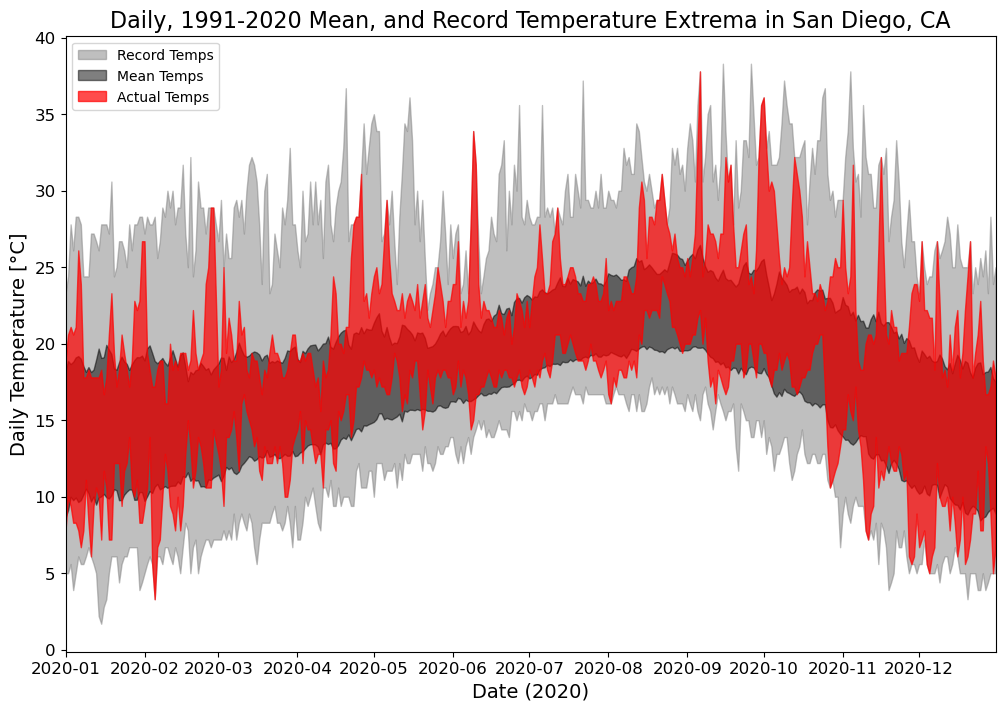

In [ ]:
# weather plot of temp extrema stats in San Diego
plt.figure(figsize=(12,8))

# plot temp extrema ranges and actual daily min/max temps
plt.fill_between(min_temp_stats.Date, 
    min_temp_stats.record_Nyrs, max_temp_stats.record_Nyrs,
    color='grey', alpha=0.5, label='Record Temps')
plt.fill_between(min_temp_stats.Date, 
    min_temp_stats.avg_Nyrs, max_temp_stats.avg_Nyrs,
    color='black', alpha=0.5, label='Mean Temps')
plt.fill_between(min_temp_stats.Date,
    min_temp_stats.TMIN, max_temp_stats.TMAX,
    color='red', alpha=0.7, label='Actual Temps')

# set title, axis titles, legend, proper font sizes
plt.title('Daily, 1991-2020 Mean, and Record Temperature Extrema in San Diego, CA', fontsize=16)
plt.xlabel('Date (2020)', fontsize=14)
plt.ylabel('Daily Temperature [°C]', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(min_temp_stats.Date.values[0], min_temp_stats.Date.values[-1])
plt.legend()